# 

In [1]:
from parameter_tuning import train_model
from rnn import PredictTime
import torch
import torch.optim as optim
import torch.nn as nn
from parse_data import get_data, get_modified_values, get_binary_values, make_data_scalar
import numpy as np
from evaluation import evaluate_model
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)


# Hyperparameters
sequence_length = [5,15,50,100,200, 150] # 2-20 increments of two
hidden_layers = [1,2]*2 # 1 and 2
hidden_1 = [2**i for i in range(3,10)] # 2^4 to 2^9
hidden_2 =[2**i for i in range(2, 5)] # 2^2 to 2^5
lr = [0.001, 0.01, 0.1, 0.005] # stop at 0.005
epochs = 100
optimizer = [optim.Adam, optim.SGD]
print(hidden_layers)

Using device:  cuda
[1, 2, 1, 2]


In [2]:

def make_data(df, device, seq_len):

    x_train, y_train = [], []
    prev = []
    m = df.max()[0]
    #print(df)
    for row in df.values:
        
        if len(prev) < seq_len:
            before = [0]*(seq_len - len(prev))
            for a in prev:
                before.append(a)
            #print(before)
            x_train.append(torch.tensor(before,device=device))
        else:   
            x_train.append(torch.tensor(prev[-seq_len:],device=device))
        y_train.append(torch.tensor(row[0]/m,device=device))
        prev.append(row[0]/m)
    return torch.stack(x_train).to(device),torch.stack(y_train).to(device)

def true_data(X,Y, device):
    new_x, new_y = [], []
    for x, y in zip(X,Y):
        for i in range(1):
            curr_x = []
            for x_part in x:
                to_add = x_part
                if to_add > 1:
                    to_add = 1
                if to_add < 0:
                    to_add = 0
                curr_x.append(to_add)
            new_x.append(torch.tensor(curr_x,device=device))
            new_y.append(torch.tensor([y]).to(device))
        
    return torch.stack(new_x).float().to(device), torch.stack(new_y).float().to(device)


def feature_engineering(X,Y, device):
    new_x, new_y = [], []
    count= 5
    for x, y in zip(X,Y):
        for i in range(count):
            curr_x = []
            for x_part in x:
                if random.random() < 1-i/(1+count):
                    to_add = x_part + np.random.normal(loc=0, scale=0.01)
                else:
                    to_add = x_part
                if to_add > 1:
                    to_add = 1
                if to_add < 0:
                    to_add = 0
                curr_x.append(to_add)
            new_x.append(torch.tensor(curr_x,device=device))
            new_y.append(torch.tensor([y]).to(device))
        #new_x.append(x)
        #new_y.append(y)
    return torch.stack(new_x).float().to(device), torch.stack(new_y).float().to(device)

x,y = make_data(get_data(), device, 10)
x_t, y_t = true_data(x,y,device)
x_d, y_d = feature_engineering(x,y, device)

#for i in range(3):
 #   print(x[i], y[i])
    


In [3]:
total_gpu_milli = 0
for i in y_t:
    total_gpu_milli += i
print(total_gpu_milli)

tensor([5717.8652], device='cuda:0')


In [4]:
import random

options = []

for seq_len in sequence_length:
    for layers in hidden_layers:
        for hidden in hidden_size:
            for forcing in [True, False]:
                for l in lr:
                    entry = {}
                    entry["seq_len"] = seq_len
                    entry["layers"] = layers
                    entry["hidden"] = hidden
                    entry["forcing"] = forcing
                    entry["l"] = l
                    options.append(entry)
                
                                         
random.shuffle(options)    

x,y = make_data(get_data(), device, 10)
x_d, y_d = feature_engineering(x,y, device)
x_t, y_t = true_data(x,y,device)



In [5]:
t = torch.tensor([1,2])
t
a = torch.cat([t, torch.tensor([1])])
a

tensor([1, 2, 1])

In [6]:
print(x_d.size())
print(x_t.size())

for i in x_t:
    print(i.size())
    break


torch.Size([40760, 10])
torch.Size([8152, 10])
torch.Size([10])


torch.Size([1])
torch.Size([10])
Running model:  {'seq_len': 15, 'layers': 2, 'hidden': 75, 'forcing': True, 'l': 0.001}  epochs:  100


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([60, 1])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[0, tensor(0.0640), tensor(0.1100)]
[10, tensor(0.0616), tensor(0.1147)]
[20, tensor(0.0614), tensor(0.1442)]
[30, tensor(0.0613), tensor(0.1235)]
[40, tensor(0.0611), tensor(0.1200)]
[50, tensor(0.0608), tensor(0.1533)]
[60, tensor(0.0606), tensor(0.1515)]
[70, tensor(0.0603), tensor(0.1279)]
[80, tensor(0.0601), tensor(0.1213)]
[90, tensor(0.0599), tensor(0.1438)]
New best model:
New loss:  [90, tensor(0.0599), tensor(0.1438)] 
Old loss:  
History: [[0, tensor(0.0640), tensor(0.1100)], [10, tensor(0.0616), tensor(0.1147)], [20, tensor(0.0614), tensor(0.1442)], [30, tensor(0.0613), tensor(0.1235)], [40, tensor(0.0611), tensor(0.1200)], [50, tensor(0.0608), tensor(0.1533)], [60, tensor(0.0606), tensor(0.1515)], [70, tensor(0.0603), tensor(0.1279)], [80, tensor(0.0601), tensor(0.1213)], [90, tensor(0.0599), tensor(0.1438)]]
tensor(6053.9751)
tensor(5705.6489)
Running model:  {'seq_len': 100, 'layers': 2, 'hidden': 50, 'forcing': False, 'l': 0.005}  epochs:  100
[0, tensor(0.0653), tenso

KeyboardInterrupt: 

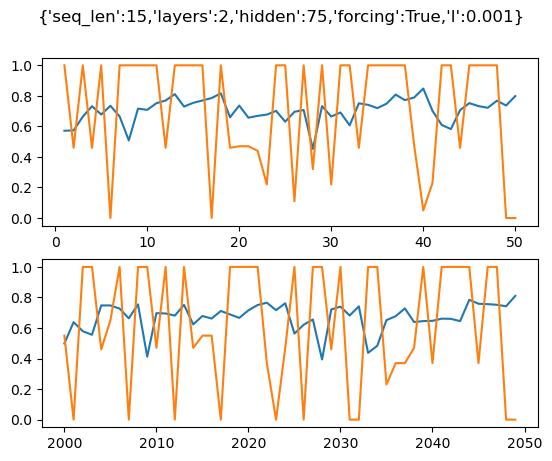

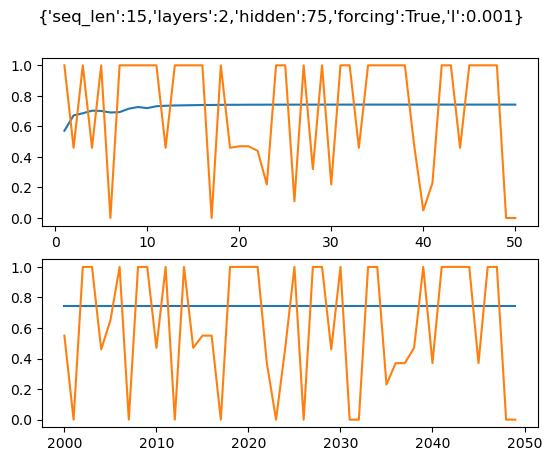

In [7]:
from IPython.display import clear_output

print(y_d[0].size())
print(x_d[0].size())

best_model = None
best_history = [""]
best_score = 100000000000000
for entry in options:
    model = PredictTime(input_size=x_d[0].size()[0],
                        output_size=y_d[0].size()[0],
                        hidden_layers=entry["layers"],
                        hidden_size=entry["hidden"],
                        device=device).to(device)
    print("Running model: ", entry, " epochs: ", epochs)
    #%lprun -f train_model train_model(model=model,x_data=x_d,y_data=y_d,sequence_length=entry["seq_len"],epochs=epochs,loss=nn.BCELoss(),optimizer=optim.Adam,strict_teacher_forcing=entry["forcing"])
    #break
    model, history = train_model(model=model,
                                 x_data=x_d,
                                 y_data=y_d,
                                 sequence_length=100,
                                 epochs=epochs,
                                 loss=nn.MSELoss(),
                                 optimizer=optim.Adam,
                                 strict_teacher_forcing=entry["forcing"])
    #clear_output()
    if history[-1][1] < best_score:
        print("New best model:\nNew loss: ", history[-1], "\nOld loss:", best_history[-1], "\nHistory:" , history[-10:])
        best_model = model
        best_history = history
        best_score = history[-1][1]
        evaluate_model(best_model, x_t, y_t, str(entry).replace(" ", ""))
    elif history[-1][2] < best_history[-1][2]:
        evaluate_model(model, x_t, y_t, str(entry).replace(" ", ""))
        print("Old model still stands:\nCurrent loss: ", history[-1], "\nBest loss:", best_history[-1])
                                 

    